In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
%matplotlib inline

In [2]:
R_earth = 6.371e6 # Earth Mean rad, in m
g_0 = 9.80665 # earth standard gravity, in m/s**2

def alt(x,y): #altitude above sea level
    return np.sqrt(x**2+y**2) - R_earth

def lon(x,y): # 2D from north pole down, @equator
    return np.arctan2(y,x)

def grav(x,y):
    assert alt(x,y) >= 0, 'must be @ or above sea level'
    h = alt(x,y)
    phi=lon(x,y)
    #print phi
    g_h = g_0*(R_earth/(R_earth+h))**2
    
    return np.array([g_h*np.cos(phi), g_h*np.sin(phi)])

    
mag = lambda x: np.sqrt(x.dot(x))
print grav(0., R_earth)

[  6.00484127e-16   9.80665000e+00]


In [3]:
"""
--------------------------
Staging for Saturn V
--------------------------
S-IC: 
Isp = 263s
m0 = 130e3 kg
mf0 = 2.16e6 kg
dmf = 12.89e3 kg/s

S-II:
Isp = 360s
m0 = 40.1e3 kg
mf0 = 456.1e3 kg

S-IVB:
Isp = 421s
m0 = 13.5e3 kg
mf0 = 109.5e3 kg
--------------------------
"""

def T_w(g, mf0): #thrust:weight ratio

    assert mf0<=2.16e6, 'Your tank is overfull (2.16e6kg max)'
    
    if (mf0>=456.1e3): # S-IC
        Isp = 263.
        m0 = 130e3
        dmf = 12.89e3
        
    elif (mf0>=109.5e3): # S-II
        Isp = 360.
        m0 = 40.1e3
        dmf=1204.
        
    elif (mf0>60e3): # S-IVB
        # note leftover stuff...too much fuel
        Isp = 421.
        m0 = 13.5e3
        dmf = 240.
    
    else: #out of fuel
        Isp = 0.
        m0 = 13.5e3
        dmf = 0.
    
    #Isp = 304  # sec
    v_e = g*Isp
    # dV = 4550  # m/s for kerbin low orbit
    #F = 18900000. #N

    #m0 = 130000. #kg
    #mf0 = 2160000 #kg
    #mf0 = 2502017*1.33# kg tsiolovsky
    #dmf = 13000.

    F = dmf*v_e

    m_t = m0 + mf0
        #dmf = 80. #kg/s
    '''
    if (m_t<=m0): # or (t>405):
            F=0.  # no more fuel
            m_t=m0 
    '''    
    #m_t = m0 + (mf0-dmf*t)
    #print 'total mass--',m_t
    #print dmf
    #print 'T:W ratio--',F/(m_t*g)
    return [F/(m_t*g), dmf]

$${dv\over dt}=-\frac{GM}{r^2}\sin\gamma-\frac{D}{m}$$
$${d\gamma\over dt}={1\over r}{\left(v-\frac{GM }{r v}\right)\cos\gamma}+\frac{L}{m v}$$
$${dr\over dt}=v\sin\gamma$$
$${d\phi\over dt}=\frac{v}{r}\cos\gamma$$

In [4]:
G = 6.672e-11 # Gravitational Constant
M = 5.97219e24 # Mass of Earth 
#M = 5.2915793e22 #Mass of Kerbin
#R = 6e5 #Radius of Kerbin
R= 6.378e6 # mean Radius of Earth

def g(y,t):

    V_i = y[0]
    gam_i=y[1]
    r_i = y[2]
    phi_i = y[3]
    mf0 = y[4]
    #assert r_i>=R, 'You have crashed'
    g = G*M/r_i**2

    tw=T_w(g, mf0)

    f_v = -g*(np.sin(gam_i) - tw[0])
    f_gam=(V_i/r_i - g/V_i)*np.cos(gam_i) # + drag/ ortho. term
    f_r = V_i*np.sin(gam_i)
    f_phi = (V_i/r_i)*np.cos(gam_i)
    
    f_m = -tw[1]
    
    check=''
    if r_i<R: check='**'
        
    #print 'time--',t, check
    #print gam_i
    return [f_v, f_gam, f_r, f_phi, f_m]

V0=  160  # m/s
gam0=np.pi/2.-0.1 # not quite vertical
r_0 = R+ 1e3 # 1/4 km up
phi0 = -1.5  # close to the bottom
mf0 = 2.16e6
#mf0 = 2502017*.84
g0=[V0, gam0, r_0, phi0, mf0]  # set init. cond. 
t=np.linspace(0,7000,7000) # 7000 secs, 10e3 steps

soln=odeint(g, g0, t) #[]
if np.where(soln[:,2]<R)[0].size==0:
    print '\nSuccessfully in orbit!'
else: print '\nYou have Crashed'


Successfully in orbit!


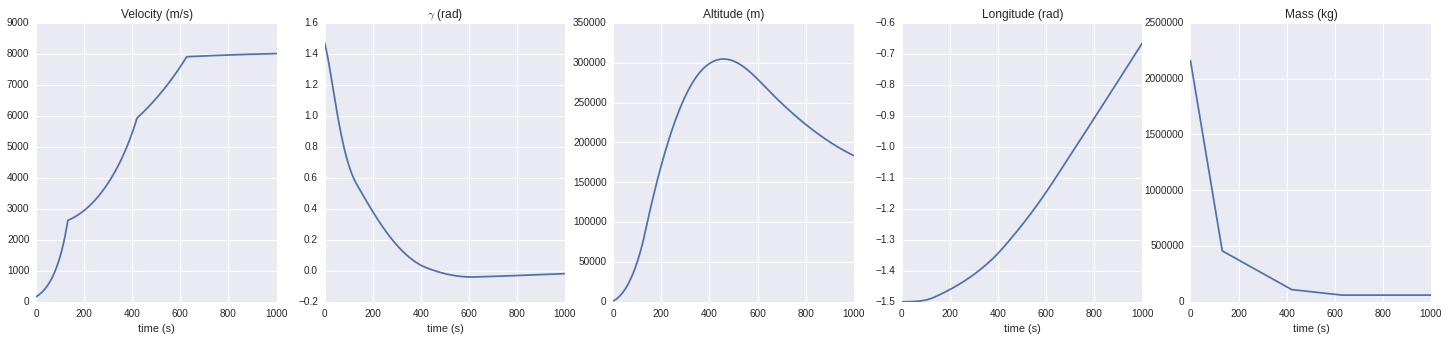

In [5]:
labels=['Velocity (m/s)',
        r'$\gamma$ (rad)',
        'Altitude (m)',
        'Longitude (rad)',
        'Mass (kg)'] 
fig,ax = plt.subplots(nrows=1, ncols=5, figsize=(25,5))
for i,n in enumerate(ax.flatten()[:5]):
    n.plot(t[:1000],soln[:1000,i])
    n.set_title(labels[i])
    n.set_xlabel('time (s)')
ax.flatten()[2].cla()
ax.flatten()[2].plot(t[:1000],soln[:1000,2]-R)
ax.flatten()[2].set_title(labels[2])

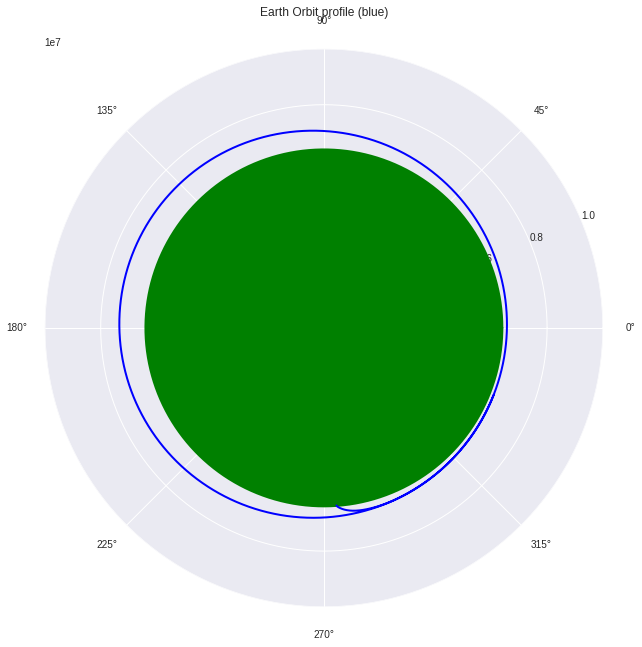

In [6]:
fig=plt.figure(figsize=(10,10))
ax1 = plt.subplot(111, polar=True) 

ax1.plot(np.linspace(0,2*np.pi, 10000),R*np.ones(10000), linewidth=3, color='g')
ax1.fill_betweenx(R*np.ones(10000), np.linspace(0,2*np.pi, 10000), color='g')
ax1.plot(soln[:,3], soln[:,2], linewidth=2, color='b')
ax1.set_ylim(0,1e7)
ax1.set_title('Earth Orbit profile (blue)')

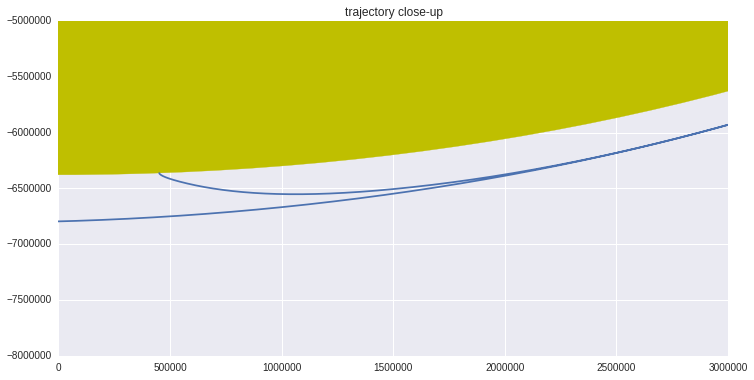

In [7]:
circle1=plt.Circle((0,0),R,color='y')

x=np.multiply(soln[:,2], np.cos(soln[:,3]))
y=np.multiply(soln[:,2], np.sin(soln[:,3]))
plt.plot(x, y)
plt.xlim(0e6,3e6)
plt.ylim(-8e6, -5e6)
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.gca().add_artist(circle1)
plt.title('trajectory close-up')